In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps

In [3]:
def get_rotmat_around_axis(angleRadian, axis):
    """
    Get a rotation matrix that rotate a vector
    with respect to an axis by some angle in radian.

    According to the right hand rule,
    if one aligns the thumb with the positive direction of the axis,
    then a positive angle is direction of your four fingers with
    a hollow fist.

    :param angleRadian:
    :param axis:
    :return:
    """

    # Check the axis length and normalize it
    if np.linalg.norm(axis) < 1e-6:
        print("The axis has to be a vector of unit length.")
        return False
    axis /= np.linalg.norm(axis)

    # Step 1: get a vector that is not parallel with the axis
    new_axis = np.zeros(3, dtype=np.float64)
    new_axis[0] = 1.0

    if np.linalg.norm(np.cross(new_axis, axis)) <= 1e-8:
        # If this relative is valid, then axis[0] ~ 1 while  axis[1] = axis[2] = 0
        new_axis[0] = 0.0
        new_axis[1] = 1.0

    # print(newAxis)

    # Step 2: remove the projection of the newAxis on the axis direction
    new_axis -= axis * np.dot(axis, new_axis)
    new_axis /= np.linalg.norm(new_axis)

    # print(newAxis)

    # Step 2: get the other vector though cross project
    new_axis2 = np.cross(axis, new_axis)

    # Construct the matrix
    rotMat = np.zeros((3, 3))
    rotMat += np.outer(axis, axis) + np.cos(angleRadian) * (np.outer(new_axis, new_axis) + np.outer(new_axis2, new_axis2))
    rotMat += np.sin(angleRadian) * (np.outer(new_axis2, new_axis) - np.outer(new_axis, new_axis2))

    return rotMat


In [13]:
Ec = 9.8  # keV
wavelength = 1.26514
kLen = np.pi * 2 / wavelength

# Get the rotation rotation matrix
angle_tmp = np.deg2rad(10)
rot_mat = get_rotmat_around_axis(angleRadian=np.deg2rad(3.49 * 2),
                                 axis=np.array([0, np.sin(angle_tmp), -np.cos(angle_tmp)]))

# Get the wavevector right in front of the mirror after the mirror 1 and the silicon 111
angle = np.deg2rad(2 * 11.639 - 0.2)
kVec = np.array([ 0, - np.sin(angle), np.cos(angle), ]) * kLen  # (x, y, z) in the xpp coordinate
kVec = np.dot(rot_mat, kVec)  # Add the rotation effect due to the mirror

# Get the reciprocal lattice of STO 220
gVec = np.array([1, 1, 0]) / np.sqrt(2) * np.pi * 2 / 1.3806

# Rotate the crystal to get a circle
angle_num = 10000
angle_list = np.linspace(start= np.deg2rad(-3.5 - 1) , stop=np.deg2rad(-3.5 + 1), num=angle_num)
#angle_list = np.linspace(start= -np.deg2rad(45) , stop=np.deg2rad(90), num=angle_num)

tilt_angle = -np.deg2rad(11.5)
tilt_mat = np.array([[np.cos(tilt_angle), 0, -np.sin(tilt_angle)],
                     [0, 1, 0],
                     [np.sin(tilt_angle), 0, np.cos(tilt_angle)],])

gVec_list = np.zeros((angle_num, 3))
for idx in range(angle_num):
    angle_rot = angle_list[idx]
    rot_mat = np.array([[1, 0, 0],
                        [0, np.cos(angle_rot), -np.sin(angle_rot)],
                        [0, np.sin(angle_rot), np.cos(angle_rot)],])

    gVec_list[idx, :] = np.dot(tilt_mat, np.dot(rot_mat, gVec))
    
# Get the transient grating wavevector
tVec = np.array([1,0,0]) * kLen * np.sin(np.deg2rad(0.1567 * 2 - 7e-3)) * 2

In [24]:
np.pi * 2 / tVec[0]

118.28904698057974

In [20]:
kout = gVec_list + kVec[np.newaxis, :]
kout_len = np.linalg.norm(kout, axis=-1)
kout_len_diff = kout_len - kLen

kout_tg = gVec_list + kVec[np.newaxis, :] + tVec[np.newaxis, :]
kout_len_tg = np.linalg.norm(kout_tg, axis=-1)
kout_len_diff_tg = kout_len_tg - kLen

kout_tg1 = gVec_list + kVec[np.newaxis, :] - tVec[np.newaxis, :]
kout_len_tg1 = np.linalg.norm(kout_tg1, axis=-1)
kout_len_diff_tg1 = kout_len_tg1 - kLen

bragg_angle = angle_list[np.argmin(np.abs(kout_len_diff))]
bragg_angle_tg = angle_list[np.argmin(np.abs(kout_len_diff_tg))]
bragg_angle_tg1 = angle_list[np.argmin(np.abs(kout_len_diff_tg1))]

print("The Bragg angle is at {:.4f} deg".format(np.rad2deg(bragg_angle)))
print("pixel",kout[np.argmin(np.abs(kout_len_diff))] / kout_tg[np.argmin(np.abs(kout_len_diff))][-1] * 115e3/75)

print("The Bragg angle with TG is at {:.4f} deg".format(np.rad2deg(bragg_angle_tg)))
print("The angular difference is {:.4f} deg".format(np.rad2deg(bragg_angle) - np.rad2deg(bragg_angle_tg)))
print("pixel",kout_tg[np.argmin(np.abs(kout_len_diff_tg))] / kout_tg[np.argmin(np.abs(kout_len_diff_tg))][-1]* 115e3/75)
print(gVec_list[np.argmin(np.abs(kout_len_diff_tg))])

print("The Bragg angle with TG is at {:.4f} deg".format(np.rad2deg(bragg_angle_tg1)))
print("The angular difference is {:.4f} deg".format(np.rad2deg(bragg_angle) - np.rad2deg(bragg_angle_tg1)))
print(kout_tg1[np.argmin(np.abs(kout_len_diff_tg1))] / kout_tg1[np.argmin(np.abs(kout_len_diff_tg1))][-1]* 115e3 / 75)

The Bragg angle is at -3.0557 deg
pixel [1216.1245266   519.83279682 1533.33333333]
The Bragg angle with TG is at -3.7113 deg
The angular difference is 0.6557 deg
pixel [1246.73591962  523.96570011 1533.33333333]
[ 3.11194801  3.21133242 -0.84570517]
The Bragg angle with TG is at -2.5000 deg
The angular difference is -0.5557 deg
[1187.35691339  516.25617432 1533.33333333]


In [22]:
idx = np.argmin(np.abs(kout_len_diff_tg))
print(kout_tg[idx] - gVec_list[idx] - kVec) 

[0.05311722 0.         0.        ]


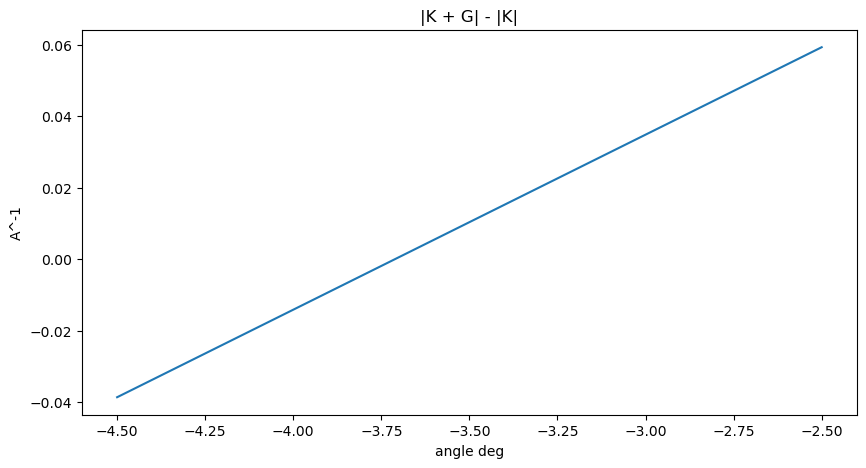

In [15]:
fig, ax = plt.subplots(ncols=1,nrows=1)
cmap = colormaps['summer']

fig.set_figheight(5)
fig.set_figwidth(10)

ax.plot(np.rad2deg(angle_list), kout_len_diff_tg)
#ax.plot(np.rad2deg(angle_list), np.abs(kout_len_diff))

plt.title('|K + G| - |K|')
plt.ylabel("A^-1")
plt.xlabel('angle deg')
#plt.legend()
plt.show()

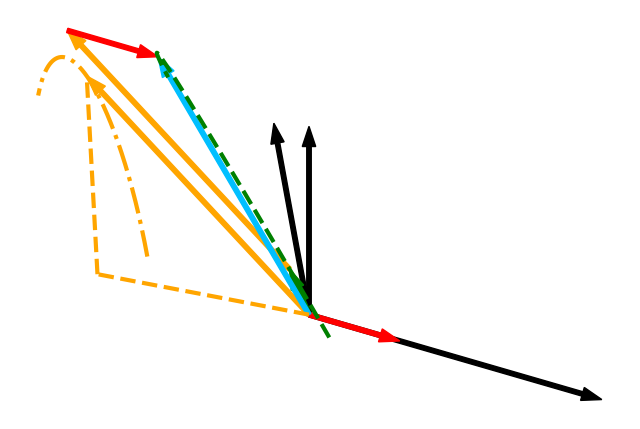

In [6]:
proj_angle = np.deg2rad(45)
proj_matrix = np.array([[1, 0, np.sin(proj_angle)],
                        [0, 1, - np.cos(proj_angle)] ,])

rotmat_plot = np.eye(3)
angle_tmp = np.deg2rad(150)
rotmat_plot[0,0] = np.cos(angle_tmp)
rotmat_plot[2,2] = np.cos(angle_tmp)
rotmat_plot[0,2] = np.sin(angle_tmp)
rotmat_plot[2,0] = -np.sin(angle_tmp)
rotmat_plot[0,:] *= 1
rotmat_plot[2,:] *= 1

zAxis = proj_matrix.dot(rotmat_plot.dot(np.array([0,0,1]))) * 5
yAxis = proj_matrix.dot(rotmat_plot.dot(np.array([0,1,0]))) * 3
xAxis = proj_matrix.dot(rotmat_plot.dot(np.array([1,0,0]))) * 4 * (-1)

# Get the incident wavevector
kin_plot = proj_matrix.dot(rotmat_plot.dot(kVec))
tg_plot = -proj_matrix.dot(rotmat_plot.dot(tVec))
g_plot = proj_matrix.dot(rotmat_plot.dot(gVec_list[np.argmin(np.abs(kout_len_diff_tg1))]))
kout_plot = proj_matrix.dot(rotmat_plot.dot(kout_tg1[np.argmin(np.abs(kout_len_diff_tg1))]))

# Get the rotation axis
rot_axis = np.array([np.cos(np.deg2rad(11.5)), 0, -np.sin(np.deg2rad(11.5))])
length = np.dot(rot_axis, gVec_list[0])
rot_axis_plot = proj_matrix.dot(rotmat_plot.dot(rot_axis)) * length

# Get the circle of the reciprocal lattice
g_heads = np.dot(rotmat_plot,gVec_list.T).T
g_heads = np.dot(proj_matrix,g_heads.T).T

# Get the circle that pass through the center along a 
start = np.copy(kVec)
stop = np.copy(kout_tg1[np.argmin(np.abs(kout_len_diff_tg1))])
steps = np.linspace( -np.pi / 12, np.pi / 2 + np.pi / 12, 1000)
arc = np.sin(steps)[:,np.newaxis] * stop[np.newaxis, :] + np.cos(steps)[:,np.newaxis] * start[np.newaxis, :]
arc_plot = (proj_matrix.dot(np.dot(rotmat_plot, arc.T))).T

# -------------------------------------Plot
fig, ax = plt.subplots(ncols=1, nrows=1)
fig.set_figheight(8)
fig.set_figwidth(8)

arrow_width = 0.08
line_width = 3
ax.arrow(x = 0, y = 0, dx = zAxis[0], dy = zAxis[1], width=arrow_width, facecolor='k')
ax.arrow(x = 0, y = 0, dx = yAxis[0], dy = yAxis[1], width=arrow_width, facecolor='k')
ax.arrow(x = 0, y = 0, dx = xAxis[0], dy = xAxis[1], width=arrow_width, facecolor='k')

ax.plot(g_heads[:,0], g_heads[:,1], c='orange', linestyle='dashdot', alpha=1, linewidth=line_width,)
ax.arrow(x = 0, y = 0, dx = g_plot[0], dy = g_plot[1], width=arrow_width, facecolor='orange', edgecolor='orange', length_includes_head=True)
#ax.arrow(x = 0, y = 0, dx = rot_axis_plot[0], dy = rot_axis_plot[1], width=0.04, facecolor='grey', edgecolor='grey', length_includes_head=True)
ax.plot([0, rot_axis_plot[0]], [0, rot_axis_plot[1]], color='orange', linestyle='--', linewidth=line_width)
ax.plot([rot_axis_plot[0], g_plot[0]], [rot_axis_plot[1], g_plot[1]], color='orange', linestyle='--', linewidth=line_width)

ax.arrow(x = 0, y = 0, dx = kin_plot[0], dy = kin_plot[1], width=arrow_width, facecolor='g', edgecolor='g', length_includes_head=True)
ax.arrow(x = 0, y = 0, dx = tg_plot[0], dy = tg_plot[1], width=arrow_width, facecolor='r', edgecolor='r', length_includes_head=True)

ax.arrow(x = kin_plot[0], y = kin_plot[1],
         dx = g_plot[0], dy = g_plot[1],
         width=arrow_width, facecolor='orange', edgecolor='orange', length_includes_head=True)
ax.arrow(x = kin_plot[0] + g_plot[0], y = kin_plot[1] + g_plot[1],
         dx = tg_plot[0], dy = tg_plot[1],
         width=arrow_width, facecolor='r', edgecolor='r', length_includes_head=True)

ax.arrow(x = 0, y = 0, dx = kout_plot[0], dy = kout_plot[1], width=arrow_width, facecolor='deepskyblue', edgecolor='deepskyblue', length_includes_head=True)
ax.plot(arc_plot[:,0], arc_plot[:,1], c='g', linestyle='--', alpha=1, linewidth=line_width,)



#plt.xlim([-1, 1])
#plt.ylim([-1, 1])
ax.set_aspect('equal')
ax.set_frame_on(False)
ax.set_axis_off()

plt.savefig("./fig1_vectors.png", dpi=300, transparent=True, bbox_inches="tight")
plt.show()


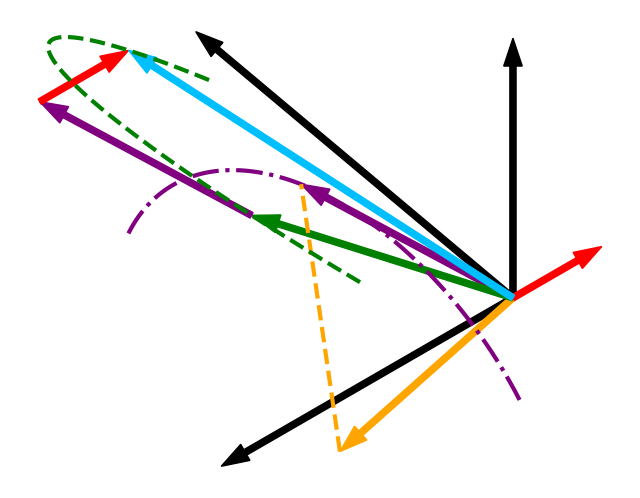

In [7]:
proj_angle = np.deg2rad(50)
proj_angle2 = np.deg2rad(-30)

proj_matrix = np.array([[np.cos(proj_angle2), 0, np.sin(proj_angle)],
                        [- np.sin(proj_angle2), 1, - np.cos(proj_angle)] ,])

rotmat_plot = np.eye(3)
angle_tmp = np.deg2rad(0)
rotmat_plot[0,0] = np.cos(angle_tmp)
rotmat_plot[2,2] = np.cos(angle_tmp)
rotmat_plot[0,2] = np.sin(angle_tmp)
rotmat_plot[2,0] = -np.sin(angle_tmp)
rotmat_plot[0,:] *= -1
rotmat_plot[2,:] *= -1

zAxis = proj_matrix.dot(rotmat_plot.dot(np.array([0,0,1]))) * 5
yAxis = proj_matrix.dot(rotmat_plot.dot(np.array([0,1,0]))) * 3
xAxis = proj_matrix.dot(rotmat_plot.dot(np.array([1,0,0]))) * 4 * (1)

# Get the incident wavevector
kin_plot = proj_matrix.dot(rotmat_plot.dot(kVec))
tg_plot = -proj_matrix.dot(rotmat_plot.dot(tVec))
g_plot = proj_matrix.dot(rotmat_plot.dot(gVec_list[np.argmin(np.abs(kout_len_diff_tg1))]))
kout_plot = proj_matrix.dot(rotmat_plot.dot(kout_tg1[np.argmin(np.abs(kout_len_diff_tg1))]))

# Get the rotation axis
rot_axis = np.array([np.cos(np.deg2rad(11.5)), 0, -np.sin(np.deg2rad(11.5))])
length = np.dot(rot_axis, gVec_list[0])
rot_axis_plot = proj_matrix.dot(rotmat_plot.dot(rot_axis)) * length

# Get the circle of the reciprocal lattice
g_heads = np.dot(rotmat_plot,gVec_list.T).T
g_heads = np.dot(proj_matrix,g_heads.T).T

# Get the circle that pass through the center along a 
start = np.copy(kVec)
stop = np.copy(kout_tg1[np.argmin(np.abs(kout_len_diff_tg1))])
steps = np.linspace( -np.pi / 12, np.pi / 2 + np.pi / 12, 1000)
arc = np.sin(steps)[:,np.newaxis] * stop[np.newaxis, :] + np.cos(steps)[:,np.newaxis] * start[np.newaxis, :]
arc_plot = (proj_matrix.dot(np.dot(rotmat_plot, arc.T))).T

# -------------------------------------Plot
fig, ax = plt.subplots(ncols=1, nrows=1)
fig.set_figheight(8)
fig.set_figwidth(8)

arrow_width = 0.08
line_width = 3
ax.arrow(x = 0, y = 0, dx = zAxis[0], dy = zAxis[1], width=arrow_width, facecolor='k')
ax.arrow(x = 0, y = 0, dx = yAxis[0], dy = yAxis[1], width=arrow_width, facecolor='k')
ax.arrow(x = 0, y = 0, dx = xAxis[0], dy = xAxis[1], width=arrow_width, facecolor='k')

ax.plot(g_heads[:,0], g_heads[:,1], c='purple', linestyle='dashdot', alpha=1, linewidth=line_width,)
ax.arrow(x = 0, y = 0, dx = g_plot[0], dy = g_plot[1], width=arrow_width, facecolor='purple', edgecolor='purple', length_includes_head=True)
#ax.arrow(x = 0, y = 0, dx = rot_axis_plot[0], dy = rot_axis_plot[1], width=0.04, facecolor='grey', edgecolor='grey', length_includes_head=True)
#ax.plot([0, rot_axis_plot[0]], [0, rot_axis_plot[1]], color='orange', linestyle='--', linewidth=line_width)
ax.arrow(x = 0, y = 0, dx = rot_axis_plot[0], dy = rot_axis_plot[1], width=arrow_width, facecolor='orange', edgecolor='orange', length_includes_head=True)
ax.plot([rot_axis_plot[0], g_plot[0]], [rot_axis_plot[1], g_plot[1]], color='orange', linestyle='--', linewidth=line_width)

ax.arrow(x = 0, y = 0, dx = kin_plot[0], dy = kin_plot[1], width=arrow_width, facecolor='g', edgecolor='g', length_includes_head=True)
ax.arrow(x = 0, y = 0, dx = tg_plot[0], dy = tg_plot[1], width=arrow_width, facecolor='r', edgecolor='r', length_includes_head=True)

ax.arrow(x = kin_plot[0], y = kin_plot[1],
         dx = g_plot[0], dy = g_plot[1],
         width=arrow_width, facecolor='purple', edgecolor='purple', length_includes_head=True)
ax.arrow(x = kin_plot[0] + g_plot[0], y = kin_plot[1] + g_plot[1],
         dx = tg_plot[0], dy = tg_plot[1],
         width=arrow_width, facecolor='r', edgecolor='r', length_includes_head=True)

ax.arrow(x = 0, y = 0, dx = kout_plot[0], dy = kout_plot[1], width=arrow_width, facecolor='deepskyblue', edgecolor='deepskyblue', length_includes_head=True)
ax.plot(arc_plot[:,0], arc_plot[:,1], c='g', linestyle='--', alpha=1, linewidth=line_width,)



#plt.xlim([-1, 1])
#plt.ylim([-1, 1])
ax.set_aspect('equal')
ax.set_frame_on(False)
ax.set_axis_off()

plt.savefig("./fig1_vectors2.png", dpi=300, transparent=True, bbox_inches="tight")
plt.show()


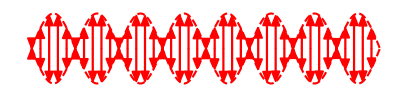

In [8]:
x_coor = np.linspace(-np.pi * 2, np.pi * 2, num=1200)
top_line = np.sin(x_coor * 2)
bottom_line = -np.sin(x_coor * 2)

arrow_axis = x_coor[::30]
arrow_top = np.sin(arrow_axis * 2)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,1))

ax.plot(x_coor, top_line, c='r', linestyle='--')
ax.plot(x_coor, bottom_line, c='r', linestyle='--')
for idx in range(arrow_axis.shape[0]):
    arrow_loc = arrow_axis[idx]
    ax.arrow(x=arrow_loc, y=0, dx=0, dy=arrow_top[idx], width=0.03, head_length=0.3, head_width=0.3, length_includes_head=True, color='r')
    ax.arrow(x=arrow_loc, y=0, dx=0, dy=-arrow_top[idx], width=0.03, head_length=0.3, head_width=0.3, length_includes_head=True, color='r')
    
ax.set_axis_off()
plt.savefig("./standingwave.png", dpi=300, bbox_inches='tight')
plt.show()

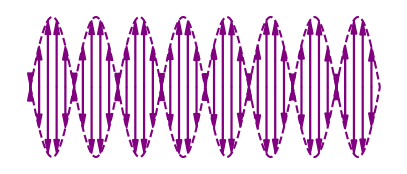

In [14]:
x_coor = np.linspace(-np.pi * 2, np.pi * 2, num=1200)
top_line = np.sin(x_coor * 2)
bottom_line = -np.sin(x_coor * 2)

arrow_axis = x_coor[::30]
arrow_top = np.sin(arrow_axis * 2)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,2))

ax.plot(x_coor, top_line, c='purple', linestyle='--')
ax.plot(x_coor, bottom_line, c='purple', linestyle='--')
for idx in range(arrow_axis.shape[0]):
    arrow_loc = arrow_axis[idx]
    ax.arrow(x=arrow_loc, y=0, dx=0, dy=arrow_top[idx], width=0.03, head_length=0.2, head_width=0.2, length_includes_head=True, color='purple')
    ax.arrow(x=arrow_loc, y=0, dx=0, dy=-arrow_top[idx], width=0.03, head_length=0.2, head_width=0.2, length_includes_head=True, color='purple')
    
ax.set_axis_off()

plt.savefig("./standingwave.png", dpi=300, bbox_inches='tight')
plt.show()

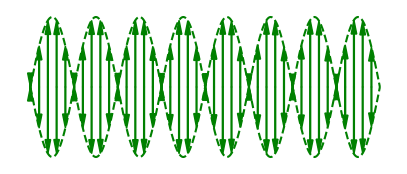

In [15]:
x_coor = np.linspace(-np.pi * 2, np.pi * 2, num=1200)
top_line = np.sin(x_coor * 2)
bottom_line = -np.sin(x_coor * 2)

arrow_axis = x_coor[::30]
arrow_top = np.sin(arrow_axis * 2)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,2))

ax.plot(x_coor, top_line, c='green', linestyle='--')
ax.plot(x_coor, bottom_line, c='green', linestyle='--')
for idx in range(arrow_axis.shape[0]):
    arrow_loc = arrow_axis[idx]
    ax.arrow(x=arrow_loc, y=0, dx=0, dy=arrow_top[idx], width=0.03, head_length=0.2, head_width=0.2, length_includes_head=True, color='green')
    ax.arrow(x=arrow_loc, y=0, dx=0, dy=-arrow_top[idx], width=0.03, head_length=0.2, head_width=0.2, length_includes_head=True, color='green')
    
ax.set_axis_off()

plt.savefig("./strain.png", dpi=300, bbox_inches='tight')
plt.show()  